In [1]:
from bigraph_schema import TypeSystem
from bigraph_viz.diagram import plot_bigraph as plt_bigraph
from bigraph_viz import plot_bigraph

In [2]:
core = TypeSystem()

In [3]:
# register some new types
def check_cobra():
    pass

core.register(
    'cobra_model', {
        '_inherit': 'string',
        })
core.register(
    'pymc_model', {
        '_inherit': 'string'
        })

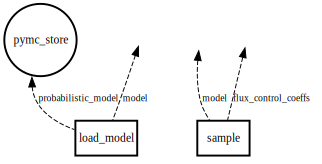

In [5]:
bmca_sample = {
    'load_model': {
        '_type': 'step',
        '_inputs': {
            'model': 'cobra_model'  # internal logic required to tell between sbml, json, yml (co-pilot integration)
        },
        '_outputs': {
            'probabilistic_model': 'pymc_model'
        },
        'inputs': {},
        'outputs': {
            'probabilistic_model': ['pymc_store']
        }
    },
    'sample': {
        '_type': 'step',
        '_inputs': {
            'model': 'pymc_model'
        },
        '_outputs': {
            'flux_control_coeffs': 'any',  # 'array[(external_metabolites|reactions),float]',
        }
    }
}
plt_bigraph(bmca_sample, core=core)

In [ ]:
from bigraph_viz import plot_bigraph

In [ ]:
bmca_sample = {
    'load_model': {
        '_type': 'step',
        '_ports': {
            # inputs
            'model': 'cobra_model',  # internal logic required to tell between sbml, json, yml (co-pilot integration)

            # outputs
            'probabilistic_model': 'pymc_model'
        },
        'wires': {
            'probabilistic_model': ['pymc_model_store']
        }
    },
    'sample': {
        '_type': 'step',
        '_ports': {
            # inputs
            'model': 'pymc_model',
            'num_samples': 'int',

            # outputs
            'flux_control_coeffs': 'control_coefficient',  # this is an object that gets filled by the model
            'metabolite_control_coeffs': 'control_coefficient',

            # other optional outputs
            'proteomics': 'maybe[array]',
            'elasticity': 'maybe[array]',
            'metabolomics': 'maybe[array]',
            'fluxes': 'maybe[array]',
        },
        'wires': {
            'model': ['pymc_model_store']
        }
    },
    'calibrate': {
        '_ports': {
            # inputs
            'model': 'pymc_model',
            'data': '',

            # outputs
            'inferred_parameters': '',
        },
        'wires': {
            'model': ['pymc_model_store']
        }
    }
}
plot_bigraph(bmca_sample)

In [ ]:
bounds_type = {
    'upper': 'float',
    'lower': 'float',
}

objective_type = 'function[array[(decisions),float],float]~string'

gene_type = 'string'
reaction_type = 'string'
metabolite_type = 'string'

perturbation_type = {
    'entity': 'reaction~gene',
    'direction': 'boolean',
}

medium_type = 'map[reaction,bounds]'

condition_type = '(medium|list[perturbation])'

spec = {
    'BMCA_workflow': {

        # top-level ports
        '_ports': {
            'input_expression': 'map[array[(genes),float]]',
            'input_model': 'sbml',
            'input_flux_data': 'maybe[array[(reactions),maybe[float]]]',
            'output_flux_control_coeff': 'array[(external_metabolites|reactions),float]',
            'output_metabolite_control_coeffs': 'array[(external_metabolites|reactions),float]',
        },

        # internal states
        'fluxes': {},
        'internal_metabolites': {},
        'external_metabolites': {},
        'enzymes': {},

        # internal processes
        'BMCA_inference': {
            '_ports': {
                'input_fluxes': 'map[array[(reactions),float]]',
                'input_enzymes': 'map[array[(enzymes), float]]',
            },
            'wires': {
                'input_fluxes': ['fluxes'],
            },
        },
        'get_flux_from_expression': {
            '_ports': {
                'input_method': 'enum[(e-flux,imat)]',  # E-flux, iMAT
                'input_expression': 'map[array[(genes),float]]',
                'input_model': 'sbml',
                'output_fluxes': 'map[array[(reactions),float]]',
                # 'output_fba_config': ''
            },
            'wires': {
                'output_fluxes': ['fluxes'],
            },
            'config': {
                'condition_normalization': 'A',
                'scaling': 'media',
            },
            'flux_variability_analysis': {
                '_ports': {
                    'input_model': 'sbml',
                    'input_conditions': '',  # media conditions
                    'output_flux_bounds': 'map[bounds]'  # from reaction to bounds, launches 2 FBAs for each
                },
                'FBA': {  # these will actually be launched following the output of FVA
                    '_ports': {
                        'input_bounds': 'array[(reactions),bounds]',
                        'input_objective': 'objective',
                        'input_model': 'sbml',
                        'output_metabolite_dual_values': 'array[(total_metabolites),float]',   # total_metabolites = internal_metabolites + external_metabolites
                        'output_reaction_dual_values': 'array[(reactions),float]',
                        'output_fluxes': 'array[(reactions),float]',
                    },
                },
            },
        },
    }
}

plot_bigraph(spec, 
             # remove_process_place_edges=True
            )

In [ ]:
help(plot_bigraph)